In [1]:
import onnxruntime
import h5py
import numpy as np
import numba
from typing import List
from numba import njit
from matplotlib import pyplot as plt
import mplhep as hep
import matplotlib


matplotlib.rcParams["figure.dpi"] = 300

In [2]:
## Algorithm to extract the best jet assignment from a set of predictions
# https://github.com/Alexanders101/SPANet/blob/master/spanet/network/prediction_selection.py


TArray = np.ndarray

TFloat32 = numba.types.float32
TInt64 = numba.types.int64

TPrediction = numba.typed.typedlist.ListType(TFloat32[::1])
TPredictions = numba.typed.typedlist.ListType(TFloat32[:, ::1])

TResult = TInt64[:, ::1]
TResults = TInt64[:, :, ::1]

NUMBA_DEBUG = False


if NUMBA_DEBUG:
    def njit(*args, **kwargs):
        def wrapper(function):
            return function
        return wrapper


@njit("void(float32[::1], int64, int64, float32)")
def mask_1(data, size, index, value):
    data[index] = value


@njit("void(float32[::1], int64, int64, float32)")
def mask_2(flat_data, size, index, value):
    data = flat_data.reshape((size, size))
    data[index, :] = value
    data[:, index] = value


@njit("void(float32[::1], int64, int64, float32)")
def mask_3(flat_data, size, index, value):
    data = flat_data.reshape((size, size, size))
    data[index, :, :] = value
    data[:, index, :] = value
    data[:, :, index] = value


# @njit("void(float32[::1], int64, int64, float32)")
# def mask_4(flat_data, size, index, value):
#     data = flat_data.reshape((size, size, size, size))
#     data[index, :, :, :] = value
#     data[:, index, :, :] = value
#     data[:, :, index, :] = value
#     data[:, :, :, index] = value


# @njit("void(float32[::1], int64, int64, float32)")
# def mask_5(flat_data, size, index, value):
#     data = flat_data.reshape((size, size, size, size, size))
#     data[index, :, :, :, :] = value
#     data[:, index, :, :, :] = value
#     data[:, :, index, :, :] = value
#     data[:, :, :, index, :] = value
#     data[:, :, :, :, index] = value
#
#
# @njit("void(float32[::1], int64, int64, float32)")
# def mask_6(flat_data, size, index, value):
#     data = flat_data.reshape((size, size, size, size, size, size))
#     data[index, :, :, :, :, :] = value
#     data[:, index, :, :, :, :] = value
#     data[:, :, index, :, :, :] = value
#     data[:, :, :, index, :, :] = value
#     data[:, :, :, :, index, :] = value
#     data[:, :, :, :, :, index] = value


# @njit("void(float32[::1], int64, int64, float32)")
# def mask_7(flat_data, size, index, value):
#     data = flat_data.reshape((size, size, size, size, size, size, size))
#     data[index, :, :, :, :, :, :] = value
#     data[:, index, :, :, :, :, :] = value
#     data[:, :, index, :, :, :, :] = value
#     data[:, :, :, index, :, :, :] = value
#     data[:, :, :, :, index, :, :] = value
#     data[:, :, :, :, :, index, :] = value
#     data[:, :, :, :, :, :, index] = value
#
#
# @njit("void(float32[::1], int64, int64, float32)")
# def mask_8(flat_data, size, index, value):
#     data = flat_data.reshape((size, size, size, size, size, size, size, size))
#     data[index, :, :, :, :, :, :, :] = value
#     data[:, index, :, :, :, :, :, :] = value
#     data[:, :, index, :, :, :, :, :] = value
#     data[:, :, :, index, :, :, :, :] = value
#     data[:, :, :, :, index, :, :, :] = value
#     data[:, :, :, :, :, index, :, :] = value
#     data[:, :, :, :, :, :, index, :] = value
#     data[:, :, :, :, :, :, :, index] = value


@njit("void(float32[::1], int64, int64, int64, float32)")
def mask_jet(data, num_partons, max_jets, index, value):
    if num_partons == 1:
        mask_1(data, max_jets, index, value)
    elif num_partons == 2:
        mask_2(data, max_jets, index, value)
    elif num_partons == 3:
        mask_3(data, max_jets, index, value)
    # elif num_partons == 4:
    #     mask_4(data, max_jets, index, value)
    # elif num_partons == 5:
    #     mask_5(data, max_jets, index, value)
    # elif num_partons == 6:
    #     mask_6(data, max_jets, index, value)
    # elif num_partons == 7:
    #     mask_7(data, max_jets, index, value)
    # elif num_partons == 8:
    #     mask_8(data, max_jets, index, value)


@njit("int64[::1](int64, int64)")
def compute_strides(num_partons, max_jets):
    strides = np.zeros(num_partons, dtype=np.int64)
    strides[-1] = 1
    for i in range(num_partons - 2, -1, -1):
        strides[i] = strides[i + 1] * max_jets

    return strides


@njit(TInt64[::1](TInt64, TInt64[::1]))
def unravel_index(index, strides):
    num_partons = strides.shape[0]
    result = np.zeros(num_partons, dtype=np.int64)

    remainder = index
    for i in range(num_partons):
        result[i] = remainder // strides[i]
        remainder %= strides[i]
    return result


@njit(TInt64(TInt64[::1], TInt64[::1]))
def ravel_index(index, strides):
    return (index * strides).sum()


@njit(numba.types.Tuple((TInt64, TInt64, TFloat32))(TPrediction))
def maximal_prediction(predictions):
    best_jet = -1
    best_prediction = -1
    best_value = -np.float32(np.inf)

    for i in range(len(predictions)):
        max_jet = np.argmax(predictions[i])
        max_value = predictions[i][max_jet]

        if max_value > best_value:
            best_prediction = i
            best_value = max_value
            best_jet = max_jet

    return best_jet, best_prediction, best_value


@njit(TResult(TPrediction, TInt64[::1], TInt64))
def extract_prediction(predictions, num_partons, max_jets):
    float_negative_inf = -np.float32(np.inf)
    max_partons = num_partons.max()
    num_targets = len(predictions)

    # Create copies of predictions for safety and calculate the output shapes
    strides = []
    for i in range(num_targets):
        strides.append(compute_strides(num_partons[i], max_jets))

    # Fill up the prediction matrix
    # -2 : Not yet assigned
    # -1 : Masked value
    # else : The actual index value
    results = np.zeros((num_targets, max_partons), np.int64) - 2

    for _ in range(num_targets):
        best_jet, best_prediction, best_value = maximal_prediction(predictions)

        if not np.isfinite(best_value):
            return results

        best_jets = unravel_index(best_jet, strides[best_prediction])

        results[best_prediction, :] = -1
        for i in range(num_partons[best_prediction]):
            results[best_prediction, i] = best_jets[i]

        predictions[best_prediction][:] = float_negative_inf
        for i in range(num_targets):
            for jet in best_jets:
                mask_jet(predictions[i], num_partons[i], max_jets, jet, float_negative_inf)
    # print((predictions))
    # print((results))
    return results#, predictions


@njit(TResults(TPredictions, TInt64[::1], TInt64, TInt64), parallel=True)
def _extract_predictions(predictions, num_partons, max_jets, batch_size):
    output = np.zeros((batch_size, len(predictions), num_partons.max()), np.int64)
    predictions = [p.copy() for p in predictions]
    # predictions_new = numba.typed.List()
    # current_prediction_new = TPredictions
    for batch in numba.prange(batch_size):
        current_prediction = numba.typed.List([prediction[batch] for prediction in predictions])
        output[batch, :, :] = extract_prediction(current_prediction, num_partons, max_jets)
        # output[batch, :, :], current_prediction_new = extract_prediction(current_prediction, num_partons, max_jets)
        # predictions_new += [current_prediction]

    return np.ascontiguousarray(output.transpose((1, 0, 2)))#, predictions_new


def extract_predictions(predictions: List[TArray]):
    flat_predictions = numba.typed.List([p.reshape((p.shape[0], -1)) for p in predictions])
    num_partons = np.array([len(p.shape) - 1 for p in predictions])
    max_jets = max(max(p.shape[1:]) for p in predictions)
    batch_size = max(p.shape[0] for p in predictions)

    results = _extract_predictions(flat_predictions, num_partons, max_jets, batch_size)
    # results, predictions_new = _extract_predictions(flat_predictions, num_partons, max_jets, batch_size)
    return [result[:, :partons] for result, partons in zip(results, num_partons)]#, [p.reshape((p.shape[0], -1)) for p in predictions_new]

In [3]:
file_name="/t3home/mmalucch//spanet_5jets_ptreg_ATLAS.onnx"

# load the model
session = onnxruntime.InferenceSession(
    file_name,
    providers=onnxruntime.get_available_providers()
)

# print the input/putput name and shape
input_name=[input.name for input in session.get_inputs()]
output_name=[output.name for output in session.get_outputs()]
print("Inputs name:", input_name)
print("Outputs name:", output_name)

input_shape=[input.shape for input in session.get_inputs()]
output_shape=[output.shape for output in session.get_outputs()]
print("Inputs shape:", input_shape)
print("Outputs shape:", output_shape)

Inputs name: ['Jet_data', 'Jet_mask']
Outputs name: ['h1_assignment_probability', 'h2_assignment_probability', 'h1_detection_probability', 'h2_detection_probability']
Inputs shape: [['batch_size', 'num_Jet', 4], ['batch_size', 'num_Jet']]
Outputs shape: [['Exph1_assignment_probability_dim_0', 'Exph1_assignment_probability_dim_1', 'Exph1_assignment_probability_dim_2'], ['Exph1_assignment_probability_dim_0', 'Exph1_assignment_probability_dim_1', 'Exph1_assignment_probability_dim_2'], ['Exph1_assignment_probability_dim_0'], ['Exph1_assignment_probability_dim_0']]


In [78]:
# load the file containing the test data
# with jet information and true assignment
filename_test="/work/mmalucch/out_hh4b/hh4b_9999_sin_cos_phi/output_JetGood_test.h5"
df_test = h5py.File(filename_test,'r')

# load the file containing ùthe predictions by spanet to check if
# the extraction algorithm is working
filename_pred="/t3home/mmalucch/out_spanet_prediction_5jets_ptreg_ATLAS.h5"
df_pred = h5py.File(filename_pred,'r')

max_event=3
# Get the input varaibles
# get the log(x+1) of the pt to be fed as input
ptPnetRegNeutrino=np.log(np.array(df_test["INPUTS"]["Jet"]["ptPnetRegNeutrino"][()])+1)[:max_event]
eta=np.array(df_test["INPUTS"]["Jet"]["eta"][()])[:max_event]
phi=np.array(df_test["INPUTS"]["Jet"]["phi"][()])   [:max_event]
btag=np.array(df_test["INPUTS"]["Jet"]["btag"][()]) [:max_event]
# stack the input variables
# the order in which the variables are stacked is important!!
input_complete=np.stack((ptPnetRegNeutrino,eta,phi,btag),axis=-1)
print(input_complete.shape)
print(input_complete)

# Get the mask containing the information
# about which jets are valid (since we consider 5 jets)
mask=np.array(df_test["INPUTS"]["Jet"]["MASK"][()][:max_event])


# create the input dictionary
x={input_name[0]:   input_complete,
    input_name[1]:   mask}


(3, 5, 4)
[[[ 3.8564816  -0.11474609 -1.5532227   0.9995117 ]
  [ 4.3559966  -0.11804199 -2.6889648   0.99902344]
  [ 4.5863276  -0.17599487 -0.24960327  0.9638672 ]
  [ 4.973516    0.36712646  2.5703125   0.90966797]
  [ 3.9454606  -0.01940536  0.40338135  0.01629639]]

 [[ 4.143105    0.08045959 -2.4833984   0.99902344]
  [ 5.0530124  -1.2502441  -0.5786133   0.9951172 ]
  [ 4.7521143  -1.8742676   0.39233398  0.9951172 ]
  [ 5.4611416  -0.44250488  2.9418945   0.97216797]
  [ 0.          0.          0.          0.        ]]

 [[ 4.635079   -1.1276855  -0.38708496  0.99560547]
  [ 4.8652177  -0.70703125  2.4750977   0.9946289 ]
  [ 4.432443   -0.8162842   1.2175293   0.98876953]
  [ 4.8063173  -0.66833496 -1.6374512   0.8964844 ]
  [ 0.          0.          0.          0.        ]]]


In [58]:
# run the model prediction
outputs = session.run(output_name, x)

In [59]:
print(len(outputs))
print(outputs[0].shape)
print(outputs[1].shape)
print(outputs[2].shape)
print(outputs[3].shape)
print(outputs[0][0])
print(outputs[1][0])

# get the true targets
idx_b1_test = df_test["TARGETS"]["h1"]["b1"][()]
idx_b2_test = df_test["TARGETS"]["h1"]["b2"][()]
idx_b3_test = df_test["TARGETS"]["h2"]["b3"][()]
idx_b4_test = df_test["TARGETS"]["h2"]["b4"][()]
print(idx_b1_test.shape)

# get the predicted targets
idx_b1_pred = df_pred["TARGETS"]["h1"]["b1"][()][:max_event]
idx_b2_pred = df_pred["TARGETS"]["h1"]["b2"][()]    [:max_event]
idx_b3_pred = df_pred["TARGETS"]["h2"]["b3"][()]    [:max_event]
idx_b4_pred = df_pred["TARGETS"]["h2"]["b4"][()]    [:max_event]

# get the predicted probabilities from the predictions file
h1_prob=df_pred["TARGETS"]["h1"]["assignment_probability"][()]  [:max_event]
h2_prob=df_pred["TARGETS"]["h2"]["assignment_probability"][()]  [:max_event]

for i in range(2):
    print(outputs[0][i])
    print(outputs[1][i])
    print("idx test", idx_b1_test[i], idx_b2_test[i], idx_b3_test[i], idx_b4_test[i])
    print("idx pred", idx_b1_pred[i], idx_b2_pred[i], idx_b3_pred[i], idx_b4_pred[i])
    print("h prob", h1_prob[i], h2_prob[i])

    print("\n")


4
(3, 5, 5)
(3, 5, 5)
(3,)
(3,)
[[0.0000000e+00 2.2281808e-04 1.1495069e-07 1.2401931e-04 9.9582564e-09]
 [2.2281808e-04 0.0000000e+00 8.3803292e-07 4.9964243e-01 1.8324774e-06]
 [1.1495069e-07 8.3803292e-07 0.0000000e+00 3.5860548e-06 1.4011460e-10]
 [1.2401931e-04 4.9964243e-01 3.5860548e-06 0.0000000e+00 4.3281375e-06]
 [9.9582564e-09 1.8324774e-06 1.4011460e-10 4.3281375e-06 0.0000000e+00]]
[[0.0000000e+00 6.6398010e-05 4.9939770e-01 2.8401175e-07 6.9324473e-05]
 [6.6398010e-05 0.0000000e+00 9.7741169e-05 2.6958940e-11 5.6810501e-07]
 [4.9939770e-01 9.7741169e-05 0.0000000e+00 5.4201127e-08 3.6791520e-04]
 [2.8401175e-07 2.6958940e-11 5.4201127e-08 0.0000000e+00 5.7382394e-11]
 [6.9324473e-05 5.6810501e-07 3.6791520e-04 5.7382394e-11 0.0000000e+00]]
(129710,)
[[0.0000000e+00 2.2281808e-04 1.1495069e-07 1.2401931e-04 9.9582564e-09]
 [2.2281808e-04 0.0000000e+00 8.3803292e-07 4.9964243e-01 1.8324774e-06]
 [1.1495069e-07 8.3803292e-07 0.0000000e+00 3.5860548e-06 1.4011460e-10]
 [1.240

In [67]:
# extract the best jet assignment from
# the predicted probabilities
probabilities=np.stack((outputs[0],outputs[1]),axis=0)
assignment_probability=[outputs[0], outputs[1]]
print("probabilities",probabilities, probabilities.shape)
print("assignment_probability",assignment_probability, len(assignment_probability), len(assignment_probability[0]), len(assignment_probability[0][0]))

probabilities [[[[0.00000000e+00 2.22818082e-04 1.14950687e-07 1.24019309e-04
    9.95825644e-09]
   [2.22818082e-04 0.00000000e+00 8.38032918e-07 4.99642432e-01
    1.83247744e-06]
   [1.14950687e-07 8.38032918e-07 0.00000000e+00 3.58605485e-06
    1.40114600e-10]
   [1.24019309e-04 4.99642432e-01 3.58605485e-06 0.00000000e+00
    4.32813749e-06]
   [9.95825644e-09 1.83247744e-06 1.40114600e-10 4.32813749e-06
    0.00000000e+00]]

  [[0.00000000e+00 3.37684880e-09 5.32724176e-09 4.99999940e-01
    0.00000000e+00]
   [3.37684880e-09 0.00000000e+00 3.71597691e-14 4.83468945e-08
    0.00000000e+00]
   [5.32724176e-09 3.71597691e-14 0.00000000e+00 1.74445625e-10
    0.00000000e+00]
   [4.99999940e-01 4.83468945e-08 1.74445625e-10 0.00000000e+00
    0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
    0.00000000e+00]]

  [[0.00000000e+00 1.03425126e-08 1.43776839e-08 6.35670292e-12
    0.00000000e+00]
   [1.03425126e-08 0.00000000e+00 4.99935150e-01 6.4829662

In [68]:

x=extract_predictions(probabilities)
# x, predictions_new=extract_predictions(assignment_probability)
print("x",x)
print("outputs 0", outputs[0])
print("outputs 1", outputs[1])
# print("predictions_new 0", predictions_new[0])
# print("predictions_new 1", predictions_new[1])
# reshape the output
y=np.concatenate([x[0],x[1]],axis=-1)
print("y",y)


predictions= np.swapaxes(x, 0, 1)
print("predictions",predictions)

# stack the assignments from the prediction file
pred_conc=np.stack((idx_b1_pred,idx_b2_pred,idx_b3_pred,idx_b4_pred),axis=-1)
print("pred_conc",pred_conc)

x [array([[1, 3],
       [0, 3],
       [1, 2]]), array([[0, 2],
       [1, 2],
       [0, 3]])]
outputs 0 [[[0.0000000e+00 2.2281808e-04 1.1495069e-07 1.2401931e-04 9.9582564e-09]
  [2.2281808e-04 0.0000000e+00 8.3803292e-07 4.9964243e-01 1.8324774e-06]
  [1.1495069e-07 8.3803292e-07 0.0000000e+00 3.5860548e-06 1.4011460e-10]
  [1.2401931e-04 4.9964243e-01 3.5860548e-06 0.0000000e+00 4.3281375e-06]
  [9.9582564e-09 1.8324774e-06 1.4011460e-10 4.3281375e-06 0.0000000e+00]]

 [[0.0000000e+00 3.3768488e-09 5.3272418e-09 4.9999994e-01 0.0000000e+00]
  [3.3768488e-09 0.0000000e+00 3.7159769e-14 4.8346894e-08 0.0000000e+00]
  [5.3272418e-09 3.7159769e-14 0.0000000e+00 1.7444562e-10 0.0000000e+00]
  [4.9999994e-01 4.8346894e-08 1.7444562e-10 0.0000000e+00 0.0000000e+00]
  [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]]

 [[0.0000000e+00 1.0342513e-08 1.4377684e-08 6.3567029e-12 0.0000000e+00]
  [1.0342513e-08 0.0000000e+00 4.9993515e-01 6.4829663e-05 0.0000000e+00]
 

Get the probabilities of the second best pairing

In [72]:
# get the probabilities of the best jet assignment
print("predictions",predictions)
probabilities=np.stack((outputs[0],outputs[1]),axis=0)
print("probabilities",probabilities)

best_pairing_probabilities_1 = probabilities[ 0, np.arange(probabilities.shape[1]),predictions[:, 0, 0], predictions[:, 0, 1]]
best_pairing_probabilities_2 = probabilities[ 1, np.arange(probabilities.shape[1]),predictions[:, 1, 0], predictions[:, 1, 1]]

print("best_pairing_probabilities_1",best_pairing_probabilities_1)
print("best_pairing_probabilities_2",best_pairing_probabilities_2)

best_pairing_probabilities_avg=(best_pairing_probabilities_1+best_pairing_probabilities_2)
print("best_pairing_probabilities_avg",best_pairing_probabilities_avg)

best_pairing_probabilities=np.ndarray((2, probabilities.shape[1]))
for i in range(2):
    best_pairing_probabilities[i] = probabilities[ i, np.arange(probabilities.shape[1]),predictions[:, i, 0], predictions[:, i, 1]]

print("best_pairing_probabilities",best_pairing_probabilities)
best_pairing_probabilities_sum=np.sum(best_pairing_probabilities,axis=0)
print("best_pairing_probabilities_sum",best_pairing_probabilities_sum)

predictions [[[1 3]
  [0 2]]

 [[0 3]
  [1 2]]

 [[1 2]
  [0 3]]]
probabilities [[[[0.00000000e+00 2.22818082e-04 1.14950687e-07 1.24019309e-04
    9.95825644e-09]
   [2.22818082e-04 0.00000000e+00 8.38032918e-07 4.99642432e-01
    1.83247744e-06]
   [1.14950687e-07 8.38032918e-07 0.00000000e+00 3.58605485e-06
    1.40114600e-10]
   [1.24019309e-04 4.99642432e-01 3.58605485e-06 0.00000000e+00
    4.32813749e-06]
   [9.95825644e-09 1.83247744e-06 1.40114600e-10 4.32813749e-06
    0.00000000e+00]]

  [[0.00000000e+00 3.37684880e-09 5.32724176e-09 4.99999940e-01
    0.00000000e+00]
   [3.37684880e-09 0.00000000e+00 3.71597691e-14 4.83468945e-08
    0.00000000e+00]
   [5.32724176e-09 3.71597691e-14 0.00000000e+00 1.74445625e-10
    0.00000000e+00]
   [4.99999940e-01 4.83468945e-08 1.74445625e-10 0.00000000e+00
    0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
    0.00000000e+00]]

  [[0.00000000e+00 1.03425126e-08 1.43776839e-08 6.35670292e-12
    0.000000

In [86]:
probabilities_new=probabilities.copy()
# set to zero the probabilities of the best jet assignment, the symmetrization and the same jet assignment on the other target
for j in range(2):
    for k in range(2):
        probabilities_new[ j, np.arange(probabilities.shape[1]),predictions[:, j, k], predictions[:, j, 1-k]] = 0
        probabilities_new[1-j, np.arange(probabilities.shape[1]), predictions[:, j, k], predictions[:, j, 1-k]] = 0

event=1
print("predictions",predictions[event])
print("probabilities\n",probabilities[:,event])
print("probabilities_new\n",probabilities_new[:,event])

predictions [[0 3]
 [1 2]]
probabilities
 [[[0.00000000e+00 3.37684880e-09 5.32724176e-09 4.99999940e-01
   0.00000000e+00]
  [3.37684880e-09 0.00000000e+00 3.71597691e-14 4.83468945e-08
   0.00000000e+00]
  [5.32724176e-09 3.71597691e-14 0.00000000e+00 1.74445625e-10
   0.00000000e+00]
  [4.99999940e-01 4.83468945e-08 1.74445625e-10 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00]]

 [[0.00000000e+00 1.37999973e-06 3.89269417e-09 2.26224616e-12
   0.00000000e+00]
  [1.37999973e-06 0.00000000e+00 4.99998569e-01 1.04704165e-08
   0.00000000e+00]
  [3.89269417e-09 4.99998569e-01 0.00000000e+00 9.49022194e-10
   0.00000000e+00]
  [2.26224616e-12 1.04704165e-08 9.49022194e-10 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00]]]
probabilities_new
 [[[0.00000000e+00 3.37684880e-09 5.32724176e-09 0.00000000e+00
   0.00000000e+00]
  [3.37684880e-09 0.00000000e+00 

In [87]:
second_best_pairing_x=extract_predictions(probabilities_new)
# print("second_best_pairing_x",second_best_pairing_x)
second_best_pairing_pred= np.swapaxes(second_best_pairing_x, 0, 1)
print("second_best_pairing_pred\n",second_best_pairing_pred[event])

second_best_pairing_pred
 [[2 3]
 [0 1]]


In [88]:
second_best_pairing_probabilities=np.ndarray((2, probabilities.shape[1]))
for i in range(2):
    second_best_pairing_probabilities[i] = probabilities_new[ i, np.arange(probabilities.shape[1]),second_best_pairing_pred[:, i, 0], second_best_pairing_pred[:, i, 1]]

print("second_best_pairing_probabilities",second_best_pairing_probabilities)
second_best_pairing_probabilities_sum=np.sum(second_best_pairing_probabilities,axis=0)
print("second_best_pairing_probabilities_sum",second_best_pairing_probabilities_sum)

second_best_pairing_probabilities [[2.22818082e-04 1.74445625e-10 6.48296627e-05]
 [3.67915200e-04 1.37999973e-06 6.12191670e-03]]
second_best_pairing_probabilities_sum [5.90733282e-04 1.38017418e-06 6.18674636e-03]


Compare the probabilities of signal evetns to the ones of 2b data

In [ ]:
file_data= "/work/mmalucch/out_hh4b/data_2b_4b_regions/output_JetGood_test.h5"
df_data = h5py.File(file_data,'r')

jet_pt_data=df_data["INPUTS"]["Jet"]["ptPnetRegNeutrino"][()][:max_event]
jet_eta_data=df_data["INPUTS"]["Jet"]["eta"][()][:max_event]
jet_phi_data=df_data["INPUTS"]["Jet"]["phi"][()][:max_event]
jet_btag_data=df_data["INPUTS"]["Jet"]["btag"][()][:max_event]

input_complete_data=np.stack((jet_pt_data,jet_eta_data,jet_phi_data,jet_btag_data),axis=-1)

mask_data=df_data["INPUTS"]["Jet"]["MASK"][()][:max_event]
x_data={input_name[0]:   input_complete_data,
    input_name[1]:   mask_data}

outputs_data = session.run(output_name, x_data)


In [ ]:
print(len(outputs_data))
print(outputs_data[0].shape)
print(outputs_data[1].shape)
print(outputs_data[2].shape)
for i in range(2):
    print(outputs_data[0][i])
    print(outputs_data[1][i])

4
(2, 5, 5)
(2, 5, 5)
(2,)
[[0.00000000e+00 8.28211923e-05 3.93302292e-02 5.73124876e-03
  4.15142506e-01]
 [8.28211923e-05 0.00000000e+00 2.20866106e-03 1.19267916e-03
  4.61688684e-03]
 [3.93302292e-02 2.20866106e-03 0.00000000e+00 1.47787454e-02
  1.21639995e-02]
 [5.73124876e-03 1.19267916e-03 1.47787454e-02 0.00000000e+00
  4.75221267e-03]
 [4.15142506e-01 4.61688684e-03 1.21639995e-02 4.75221267e-03
  0.00000000e+00]]
[[0.0000000e+00 4.9994493e-01 7.6858341e-06 3.2725252e-06 4.1940046e-05]
 [4.9994493e-01 0.0000000e+00 4.5780183e-07 1.4803265e-07 1.5731486e-06]
 [7.6858341e-06 4.5780183e-07 0.0000000e+00 1.9610240e-13 2.5498069e-12]
 [3.2725252e-06 1.4803265e-07 1.9610240e-13 0.0000000e+00 1.3873376e-12]
 [4.1940046e-05 1.5731486e-06 2.5498069e-12 1.3873376e-12 0.0000000e+00]]
[[0.         0.30775315 0.01569694 0.06869957 0.        ]
 [0.30775315 0.         0.0072121  0.03102959 0.        ]
 [0.01569694 0.0072121  0.         0.06960861 0.        ]
 [0.06869957 0.03102959 0.069608

In [ ]:
assignment_probability_data=[outputs_data[0],outputs_data[1]]
x_data=extract_predictions(assignment_probability_data)

print("x_data",x_data)
print("outputs_data 0", outputs_data[0])
print("outputs_data 1", outputs_data[1])


x_data [array([[2, 3],
       [2, 3]]), array([[0, 1],
       [0, 1]])]
outputs_data 0 [[[0.00000000e+00 8.28211923e-05 3.93302292e-02 5.73124876e-03
   4.15142506e-01]
  [8.28211923e-05 0.00000000e+00 2.20866106e-03 1.19267916e-03
   4.61688684e-03]
  [3.93302292e-02 2.20866106e-03 0.00000000e+00 1.47787454e-02
   1.21639995e-02]
  [5.73124876e-03 1.19267916e-03 1.47787454e-02 0.00000000e+00
   4.75221267e-03]
  [4.15142506e-01 4.61688684e-03 1.21639995e-02 4.75221267e-03
   0.00000000e+00]]

 [[0.00000000e+00 3.07753146e-01 1.56969372e-02 6.86995685e-02
   0.00000000e+00]
  [3.07753146e-01 0.00000000e+00 7.21209776e-03 3.10295876e-02
   0.00000000e+00]
  [1.56969372e-02 7.21209776e-03 0.00000000e+00 6.96086138e-02
   0.00000000e+00]
  [6.86995685e-02 3.10295876e-02 6.96086138e-02 0.00000000e+00
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00]]]
outputs_data 1 [[[0.0000000e+00 4.9994493e-01 7.6858341e-06 3.2725252e-06 4.1940046e-05]


In [ ]:
probabilities_data=[]
outputs_data_new=[outputs_data[0].copy(),outputs_data[1].copy()]
for i in range(len(x_data[0])):
    # print(x_data[0][i])
    # print(outputs_data[0][i][x_data[0][i][0],x_data[0][i][1]])
    # print(x_data[1][i])
    # print(outputs_data[1][i][x_data[1][i][0],x_data[1][i][1]])
    # print("\n")
    probabilities_data.append([outputs_data[0][i][x_data[0][i][0],x_data[0][i][1]]*2,outputs_data[1][i][x_data[1][i][0],x_data[1][i][1]]*2])
    # outputs_data_new[0][i][x_data[0][i][0],x_data[0][i][1]]=0
    # outputs_data_new[0][i][x_data[0][i][1],x_data[0][i][0]]=0

    # outputs_data_new[1][i][x_data[1][i][0],x_data[1][i][1]]=0
    # outputs_data_new[1][i][x_data[1][i][1],x_data[1][i][0]]=0

    for j in range(2):
        for k in range(2):
            outputs_data_new[j][i][x_data[j][i][k],x_data[j][i][1-k]]=0
            outputs_data_new[j][i][x_data[1-j][i][k],x_data[1-j][i][1-k]]=0

print("probabilities_data",probabilities_data)
print("outputs_data_new 0", outputs_data_new[0])
print("outputs_data_new 1", outputs_data_new[1])

probabilities_data [[0.029557490721344948, 0.9998898506164551], [0.13921722769737244, 0.9999018907546997]]
outputs_data_new 0 [[[0.         0.         0.03933023 0.00573125 0.4151425 ]
  [0.         0.         0.00220866 0.00119268 0.00461689]
  [0.03933023 0.00220866 0.         0.         0.012164  ]
  [0.00573125 0.00119268 0.         0.         0.00475221]
  [0.4151425  0.00461689 0.012164   0.00475221 0.        ]]

 [[0.         0.         0.01569694 0.06869957 0.        ]
  [0.         0.         0.0072121  0.03102959 0.        ]
  [0.01569694 0.0072121  0.         0.         0.        ]
  [0.06869957 0.03102959 0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]]]
outputs_data_new 1 [[[0.0000000e+00 0.0000000e+00 7.6858341e-06 3.2725252e-06 4.1940046e-05]
  [0.0000000e+00 0.0000000e+00 4.5780183e-07 1.4803265e-07 1.5731486e-06]
  [7.6858341e-06 4.5780183e-07 0.0000000e+00 0.0000000e+00 2.5498069e-12]
  [3.2725252e-06 1.4803265e-07 0.000000

get second best pairing probabilities

In [ ]:
probabilities_data_new=[]
assignment_probability_data_new=[outputs_data_new[0],outputs_data_new[1]]
x_data_new=extract_predictions(assignment_probability_data_new)
print("x_data_new",x_data_new)

for i in range(len(x_data[0])):
    # print(x_data_new[0][i])
    # print(outputs_data_new[0][i][x_data_new[0][i][0],x_data_new[0][i][1]])
    # print(x_data_new[1][i])
    # print(outputs_data_new[1][i][x_data_new[1][i][0],x_data_new[1][i][1]])
    # print("\n")
    probabilities_data_new.append([outputs_data_new[0][i][x_data_new[0][i][0],x_data_new[0][i][1]]*2,outputs_data_new[1][i][x_data_new[1][i][0],x_data_new[1][i][1]]*2])

print("probabilities_data_new",probabilities_data_new)


x_data_new [array([[0, 4],
       [0, 3]]), array([[1, 2],
       [1, 2]])]
probabilities_data_new [[0.8302850127220154, 9.156036639978993e-07], [0.13739913702011108, 3.721909706655424e-06]]


plot the probabilities of the first best pairing for signal and 2b data

In [ ]:
probabilities_avg=[]
for i in range(len(probabilities)):
    probabilities_avg.append((probabilities[i][0]+probabilities[i][1])/2)
print("probabilities_avg",probabilities_avg)

probabilities_new_avg=[]
for i in range(len(probabilities_new)):
    probabilities_new_avg.append((probabilities_new[i][0]+probabilities_new[i][1])/2)
print("probabilities_new_avg",probabilities_new_avg)

probabilities_data_avg=[]
for i in range(len(probabilities_data)):
    probabilities_data_avg.append((probabilities_data[i][0]+probabilities_data[i][1])/2)
print("probabilities_data_avg",probabilities_data_avg)
probabilities_data_avg=np.array(probabilities_data_avg)

probabilities_data_new_avg=[]
for i in range(len(probabilities_data_new)):
    probabilities_data_new_avg.append((probabilities_data_new[i][0]+probabilities_data_new[i][1])/2)
print("probabilities_data_new_avg",probabilities_data_new_avg)
probabilities_data_new_avg=np.array(probabilities_data_new_avg)


probabilities_avg [0.9990401268005371, 0.9999985098838806]
probabilities_new_avg [0.0005907332815695554, 1.3801741761132469e-06]
probabilities_data_avg [0.5147236706689, 0.5695595592260361]
probabilities_data_new_avg [0.4151429641628397, 0.06870142946490887]


In [ ]:
print(probabilities_data_avg[probabilities_data_avg<0.2])
print(probabilities_data_new_avg[probabilities_data_avg<0.2])
print(len(assignment_probability_data_new))
print((assignment_probability_data_new[0][probabilities_data_avg<0.2][0]))
print((assignment_probability_data_new[1][probabilities_data_avg<0.2][0]))
# assignment_probability_data_new=np.array(assignment_probability_data_new)

[]
[]
2


IndexError: index 0 is out of bounds for axis 0 with size 0

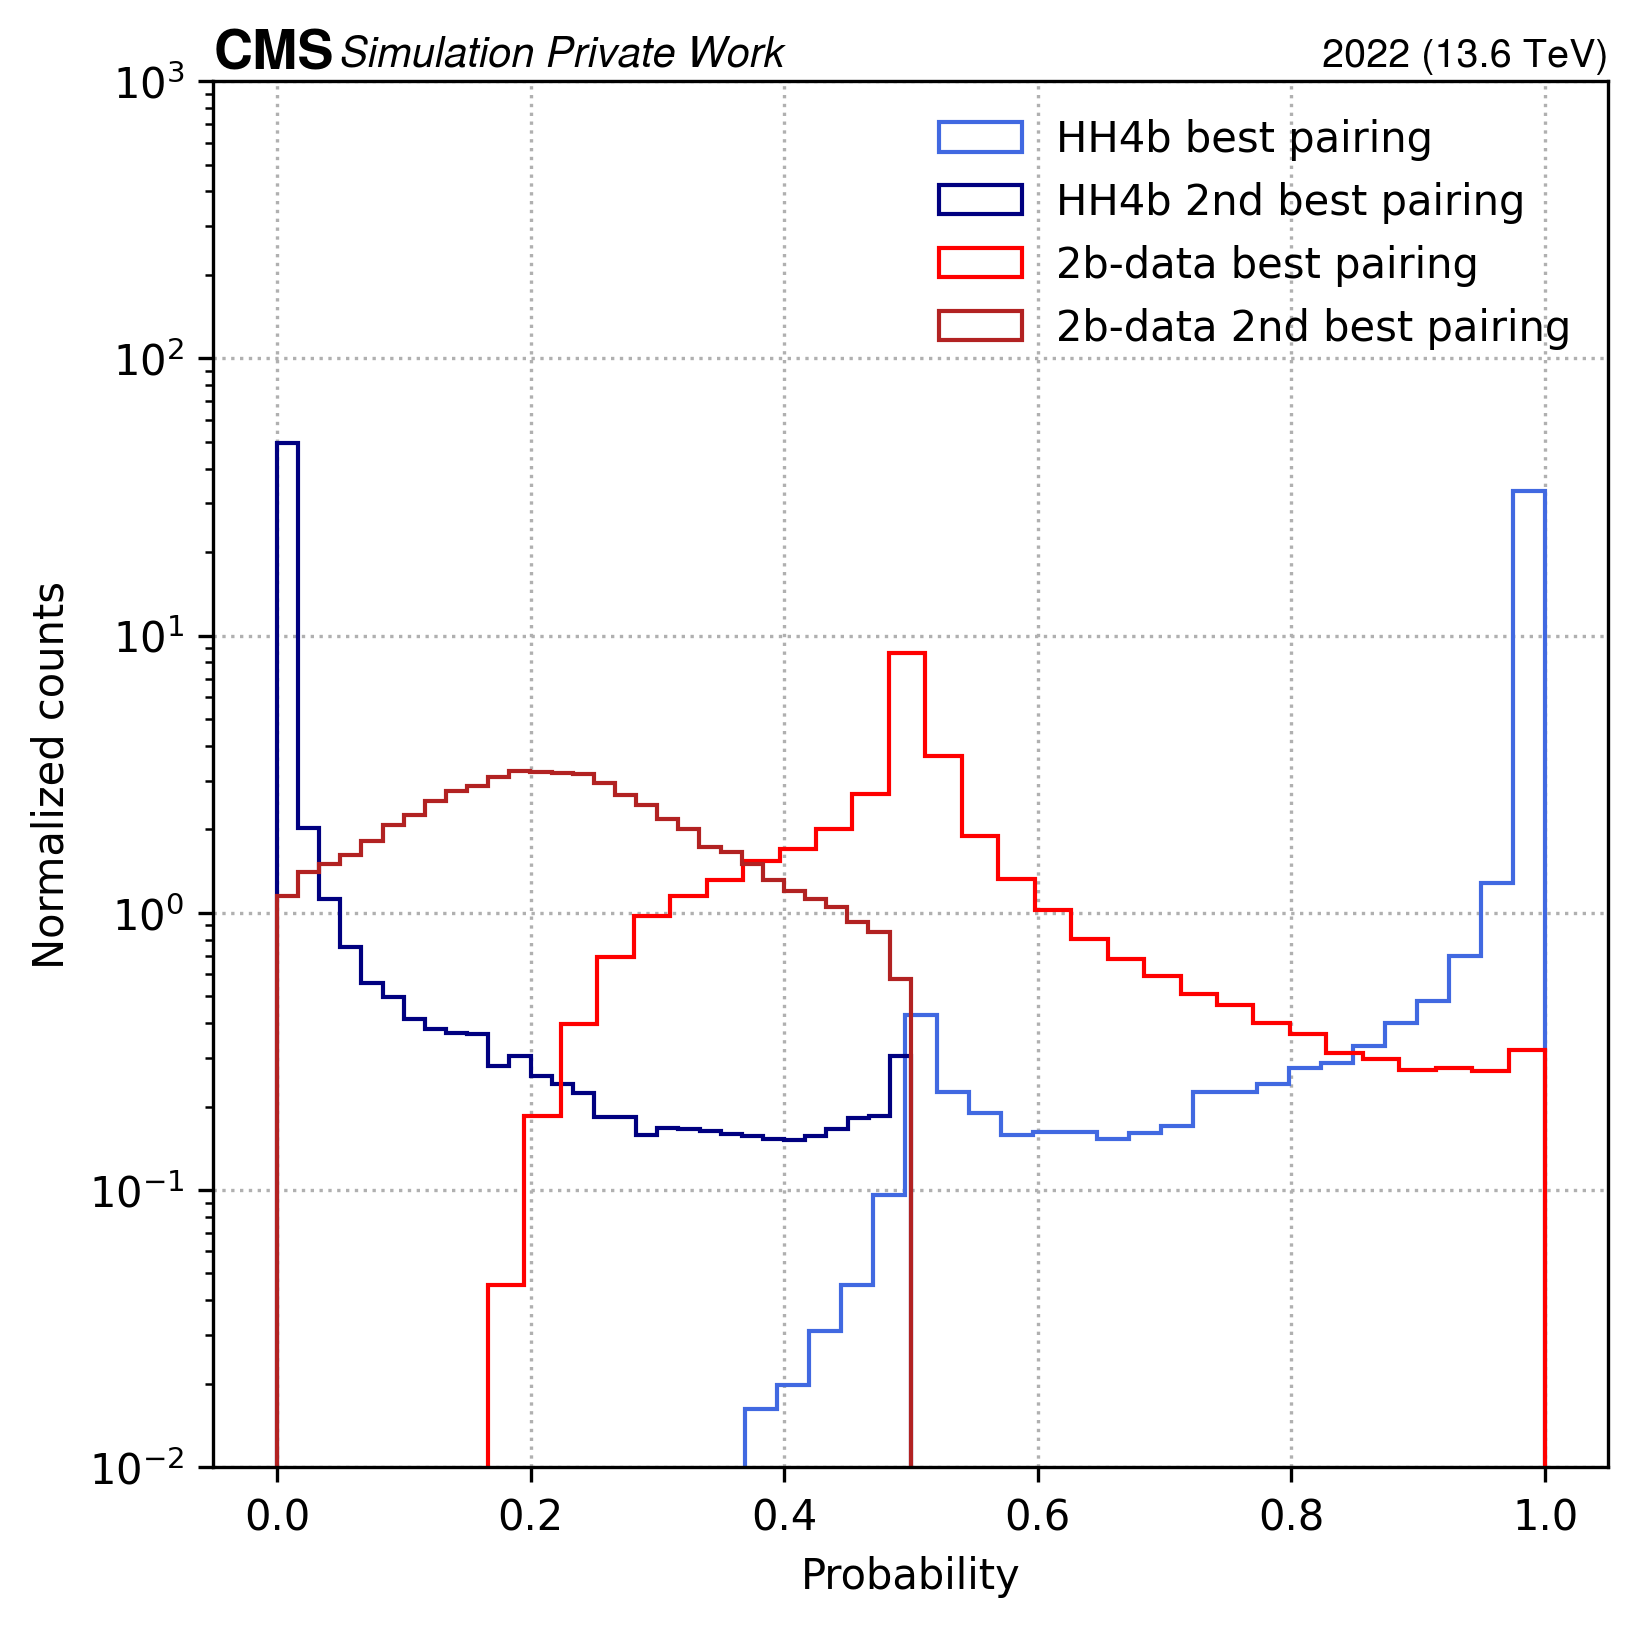

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.hist(probabilities_avg, bins=30, histtype='step', label='HH4b best pairing', color="royalblue", density=True)
ax.hist(probabilities_new_avg, bins=30, histtype='step', label='HH4b 2nd best pairing', color="navy", density=True)
ax.hist(probabilities_data_avg, bins=30, histtype='step', label='2b-data best pairing', color="red", density=True)
ax.hist(probabilities_data_new_avg, bins=30, histtype='step', label='2b-data 2nd best pairing', color="firebrick", density=True)
hep.cms.label(
            year="2022",
            com="13.6",
            label=f"Private Work",
            ax=ax,
        )

#log scale
ax.set_yscale('log')
ax.grid(linestyle=":")

#cut the y axis at 0.01
plt.ylim(0.01, 1000)
ax.legend(frameon=False, loc="upper right")
ax.set_xlabel("Probability")
ax.set_ylabel("Normalized counts")

plt.show()


plot the difference of the probabilities of the first best pairing for signal and 2b data

probabilities_diff [-4.49259602e-03 -1.40109677e-02 -9.53842700e-03 -4.10142306e-04
 -1.88766248e-02 -7.54197551e-03 -3.05822045e-02 -1.41612403e-02
 -7.33242019e-03 -4.43125404e-02 -1.71808135e-02 -3.41604240e-02
 -8.12177360e-03 -5.50798625e-02 -1.02719259e-02 -8.00874010e-02
 -5.96850761e-02 -4.50302809e-02 -1.20021680e-04 -1.45267695e-02
 -1.05211842e-01 -1.90876343e-01 -1.18068893e-03 -2.77304649e-03
 -3.67704257e-02 -5.38028963e-02 -6.66266307e-04 -7.29159363e-02
 -4.26869255e-02 -3.79016553e-02 -1.44922859e-02 -2.86368753e-02
 -2.23675668e-02 -8.84277895e-02 -9.27817784e-02 -1.00914359e-01
 -1.23306308e-02 -7.53687966e-02 -2.58658971e-02 -8.15577870e-02
 -1.20880008e-02 -7.53840144e-02 -2.58292267e-02 -6.85254056e-02
 -1.04629357e-02 -4.23210940e-02 -1.77303630e-01 -3.43871809e-03
 -2.02624276e-02 -1.44538879e-02 -3.77599294e-02 -1.91727529e-01
 -2.02924460e-02 -1.36508655e-01 -5.97707927e-04 -4.09574348e-03
 -7.67519996e-02 -6.39675814e-03 -6.01454079e-03 -9.86137241e-03
 -9.37

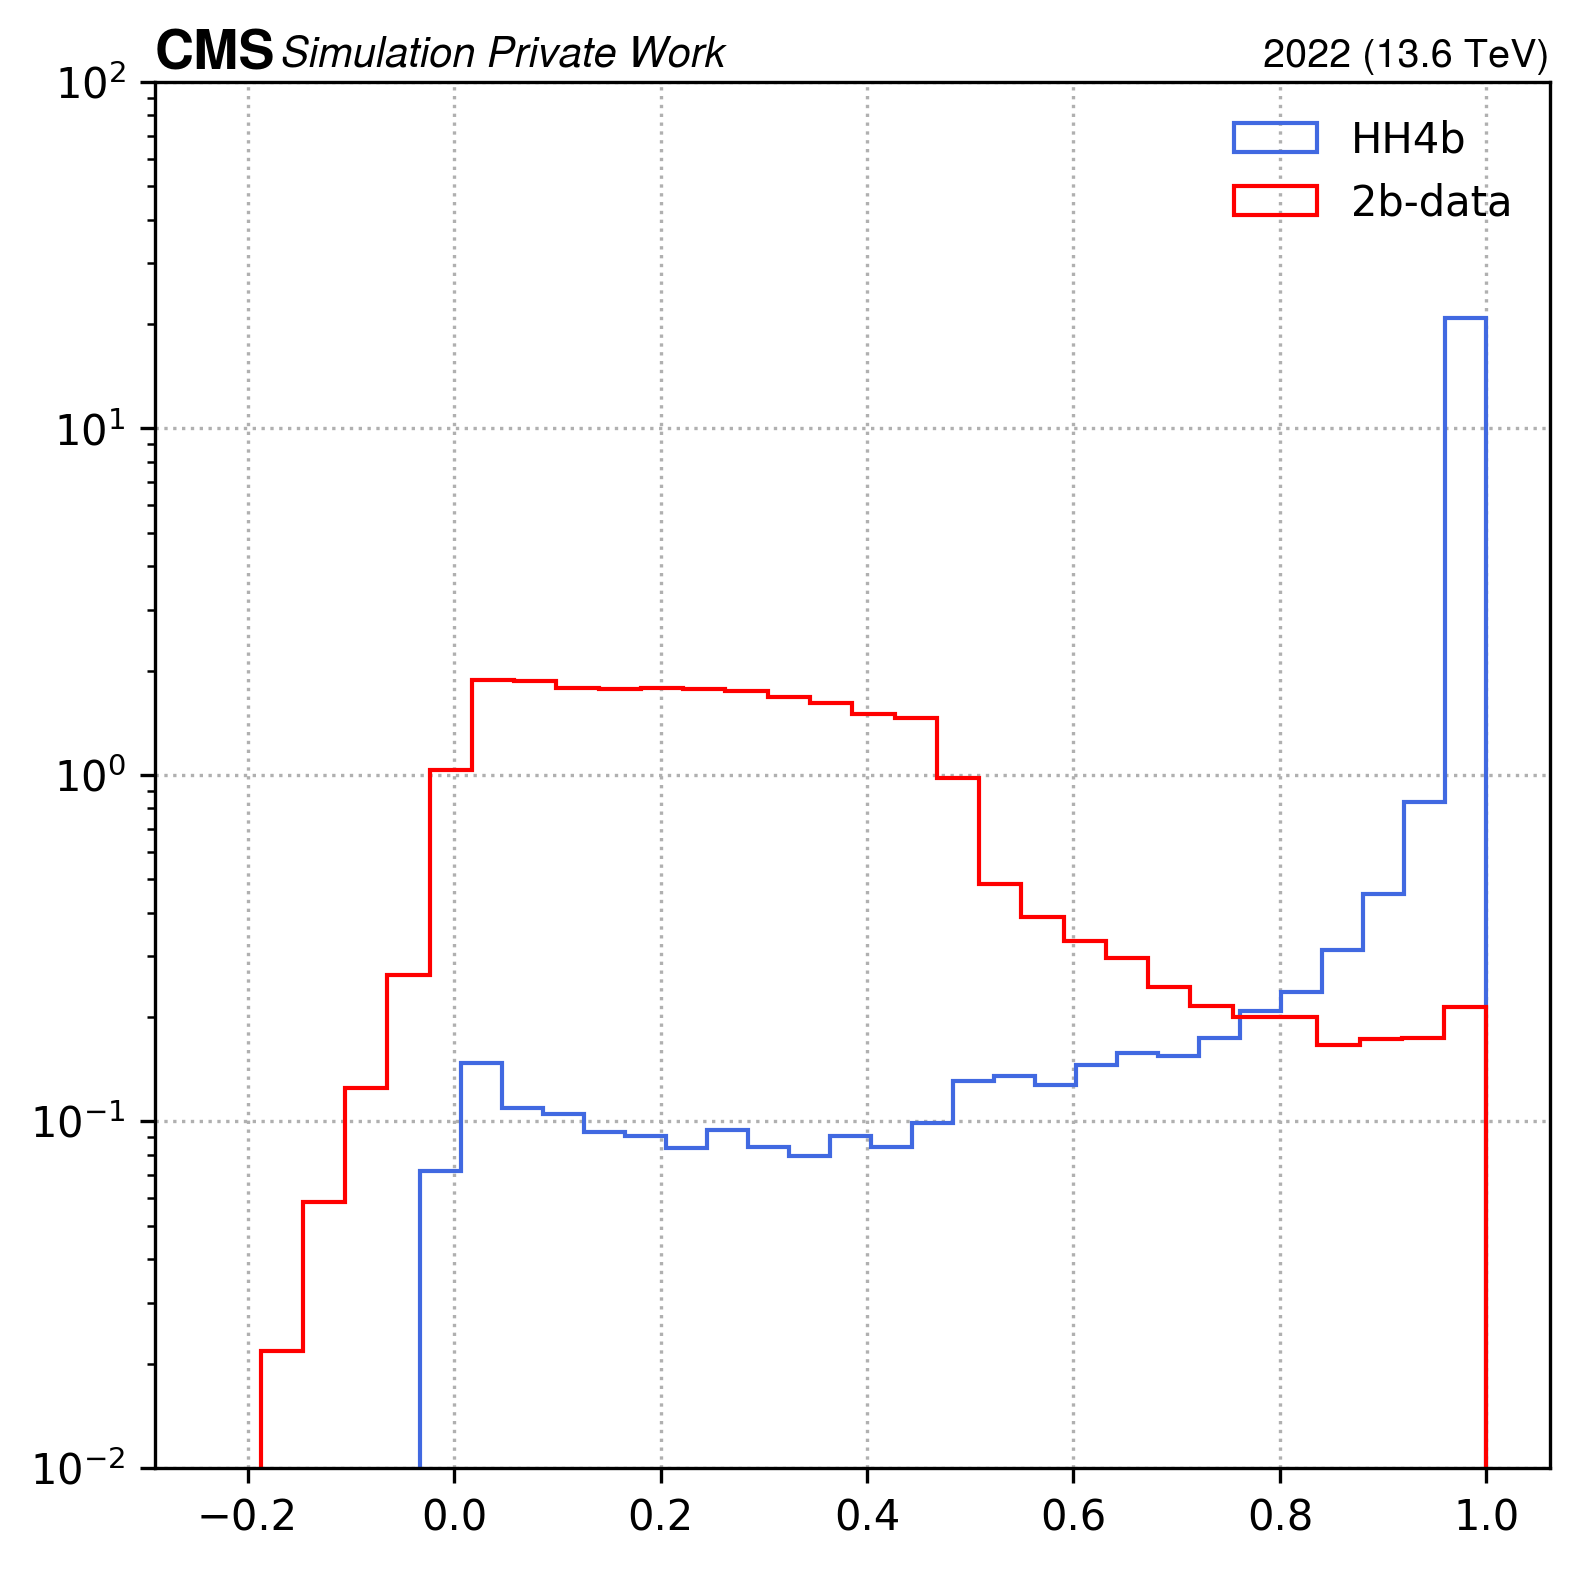

In [ ]:
probabilities_diff=[]
for i in range(len(probabilities)):
    probabilities_diff.append(probabilities_avg[i]-probabilities_new_avg[i])
probabilities_diff=np.array(probabilities_diff)
print("probabilities_diff",probabilities_diff[probabilities_diff<0])

probabilities_data_diff=[]
for i in range(len(probabilities_data)):
    probabilities_data_diff.append(probabilities_data_avg[i]-probabilities_data_new_avg[i])
print("probabilities_data_diff",probabilities_data_diff)


fig, ax = plt.subplots(figsize=(6, 6))
ax.hist(probabilities_diff, bins=30, histtype='step', label='HH4b', density=True, color="royalblue")
ax.hist(probabilities_data_diff, bins=30, histtype='step', label='2b-data', density=True, color="red")
#log scale
hep.cms.label(
            year="2022",
            com="13.6",
            label=f"Private Work",
            ax=ax,
        )

#log scale
ax.set_yscale('log')
ax.grid(linestyle=":")

#cut the y axis at 0.01
plt.ylim(0.01, 100)
ax.legend(frameon=False, loc="upper right")
plt.show()


probabilities_diff_arctanh [3.5807403615556392, 6.727121565241922, 2.5395091216853203, 2.2774771140162997, 2.6115678225124768, 6.9216484764705415, 6.621128147416955, 1.6980785337536206, 4.005093760349578, 4.693736843531414, 3.775089496046066, 8.36287897601719, 6.553914832276426, 2.9654075232538952, 3.6377629739240054, 5.778059202871498, 4.532537607686063, 2.249217800612921, 4.109596320164252, 4.513269578581838, 3.7178956911418557, 7.083626693293321, 8.276628339933445, 6.46451595327061, 4.454507424804526, 3.193657494396777, 4.438320604779327, 0.8112681220264936, 3.3398272163852183, 4.410175981260388, 0.8233016248168948, 2.7902903025879624, 2.468088862238883, 5.328407359473453, 3.8970176393494347, 4.462053307562055, 3.2032232288049745, 6.422037699424308, 3.6890249336913126, 5.592663411760857, 4.330304121857319, 4.846377878040843, 2.761490257552451, 5.62780659279464, 1.5140006881059849, 7.9879111331472314, 4.232439799752912, 5.161793088575594, 2.119160271077288, 5.749861510117619, 3.91555

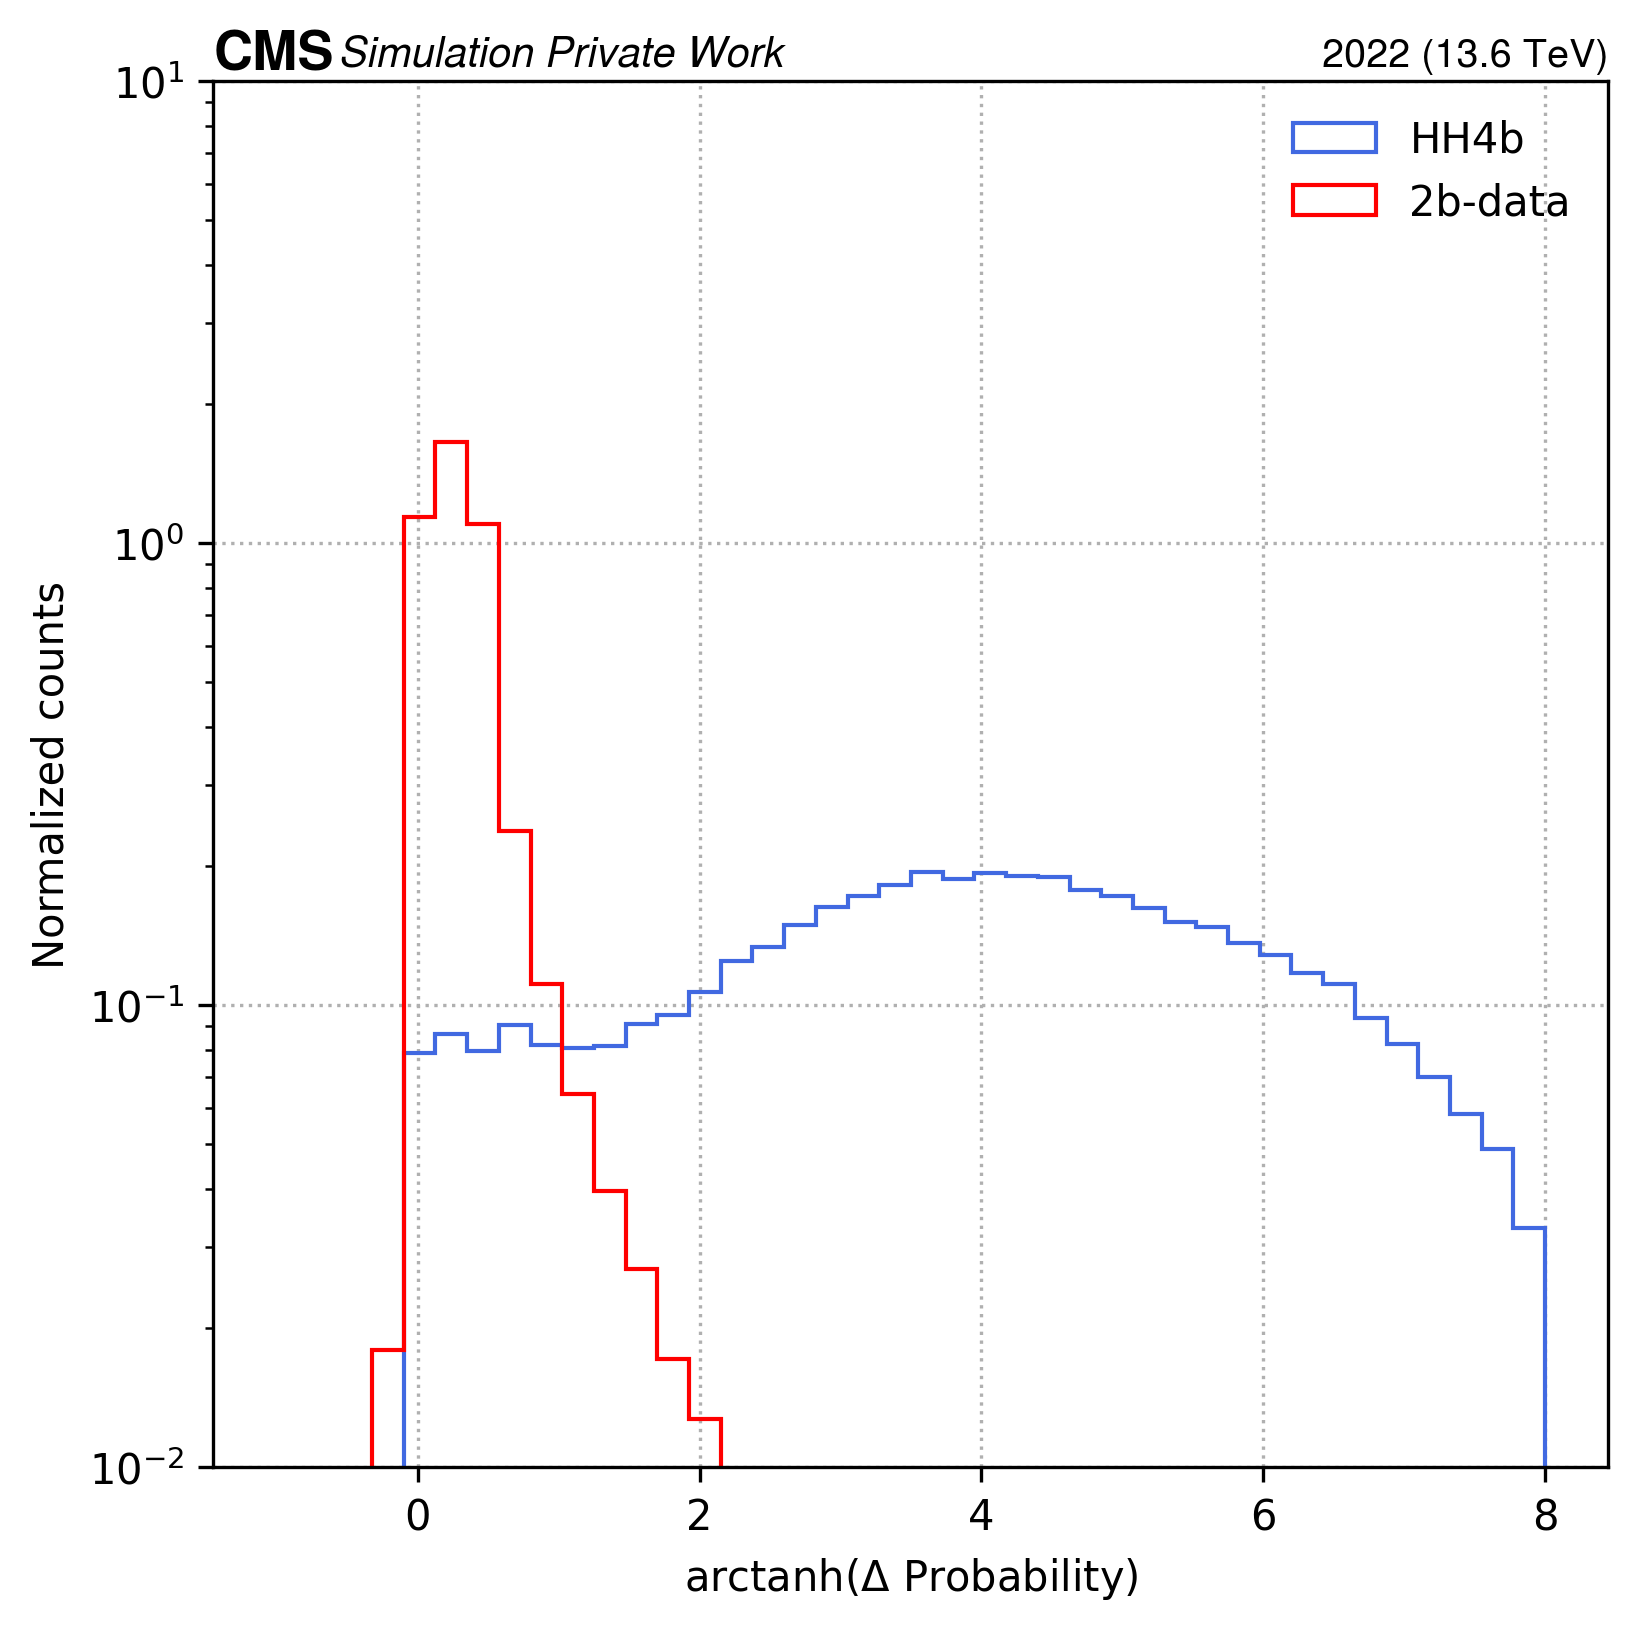

In [ ]:
# plot the arctanhh of the difference
probabilities_diff_arctanh=[]
for i in range(len(probabilities_diff)):
    probabilities_diff_arctanh.append(np.arctanh(probabilities_diff[i]))
print("probabilities_diff_arctanh",probabilities_diff_arctanh)

probabilities_data_diff_arctanh=[]
for i in range(len(probabilities_data_diff)):
    probabilities_data_diff_arctanh.append(np.arctanh(probabilities_data_diff[i]))
print("probabilities_data_diff_arctanh",probabilities_data_diff_arctanh)

fig, ax = plt.subplots(figsize=(6, 6))
ax.hist(probabilities_diff_arctanh, bins=40, histtype='step', label='HH4b', range=(-1,8), density=True, color="royalblue")
ax.hist(probabilities_data_diff_arctanh, bins=40, histtype='step', label='2b-data', range=(-1,8), density=True, color="red")
#log scale
hep.cms.label(
            year="2022",
            com="13.6",
            label=f"Private Work",
            ax=ax,
        )

#log scale
ax.set_yscale('log')
ax.grid(linestyle=":")

#cut the y axis at 0.01
plt.ylim(0.01, 10)
ax.legend(frameon=False, loc="upper right")
ax.set_xlabel(r"arctanh($\Delta$ Probability)")
ax.set_ylabel("Normalized counts")
plt.show()
